In [1]:
import os
import random
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

class FaceDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, return_original=False):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.return_original = return_original
        
        if split == 'train':
            self.data_dir = os.path.join(root_dir, 'classification_data', 'train_data')
        elif split == 'val':
            self.data_dir = os.path.join(root_dir, 'classification_data', 'val_data')
        elif split == 'test':
            self.data_dir = os.path.join(root_dir, 'classification_data', 'test_data')
        else:
            raise ValueError("Mode must be 'train', 'val', or 'test'")
        
        self.classes = os.listdir(self.data_dir)
        self.image_paths = self._get_image_paths()
        
        if split in ['val', 'test']:
            self.pairs = self._load_verification_pairs()

    def _get_image_paths(self):
        image_paths = []
        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            for img_name in os.listdir(class_dir):
                image_paths.append(os.path.join(class_dir, img_name))
        return image_paths

    def _load_verification_pairs(self):
        pairs_file = os.path.join(self.root_dir, 'verification_pairs_val.txt')
        pairs = []
        with open(pairs_file, 'r') as f:
            for line in f:
                img1_path, img2_path, label = line.strip().split()
                pairs.append((
                    os.path.join(self.root_dir, img1_path),
                    os.path.join(self.root_dir, img2_path),
                    int(label)
                ))
        return pairs

    def __len__(self):
        if self.split == 'train':
            return len(self.image_paths)
        else:
            return len(self.pairs)

    def __getitem__(self, idx):
        if self.split == 'train':
            img1_path = self.image_paths[idx]
            img1 = Image.open(img1_path).convert('RGB')
            
            same_class = random.choice([0, 1])
            
            if same_class:
                img2_path = random.choice([p for p in self.image_paths if os.path.dirname(p) == os.path.dirname(img1_path)])
            else:
                img2_path = random.choice([p for p in self.image_paths if os.path.dirname(p) != os.path.dirname(img1_path)])
            
            img2 = Image.open(img2_path).convert('RGB')
            label = same_class
        else:
            img1_path, img2_path, label = self.pairs[idx]
            img1 = Image.open(img1_path).convert('RGB')
            img2 = Image.open(img2_path).convert('RGB')
        
        if self.return_original:
            return img1, img2, label
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, torch.tensor(label, dtype=torch.float32)

def visualize_pairs(dataset, num_pairs=5):
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 4*num_pairs))
    for i in range(num_pairs):
        img1, img2, label = dataset[random.randint(0, len(dataset)-1)]
        axes[i, 0].imshow(img1)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(img2)
        axes[i, 1].axis('off')
        axes[i, 0].set_title(f"Pair {i+1}")
        axes[i, 1].set_title(f"Same: {bool(label)}")
    plt.tight_layout()
    plt.show()


Training samples: 380638
Validation samples: 8805
Test samples: 8805


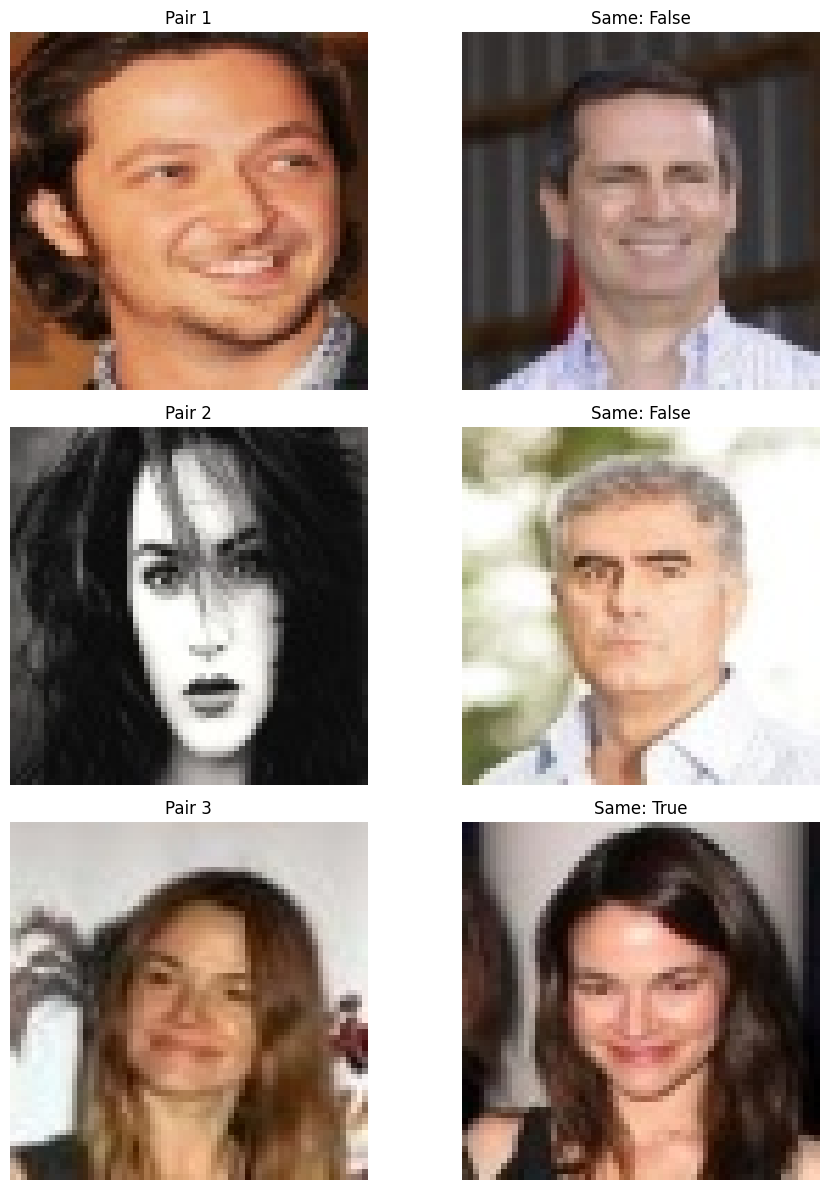

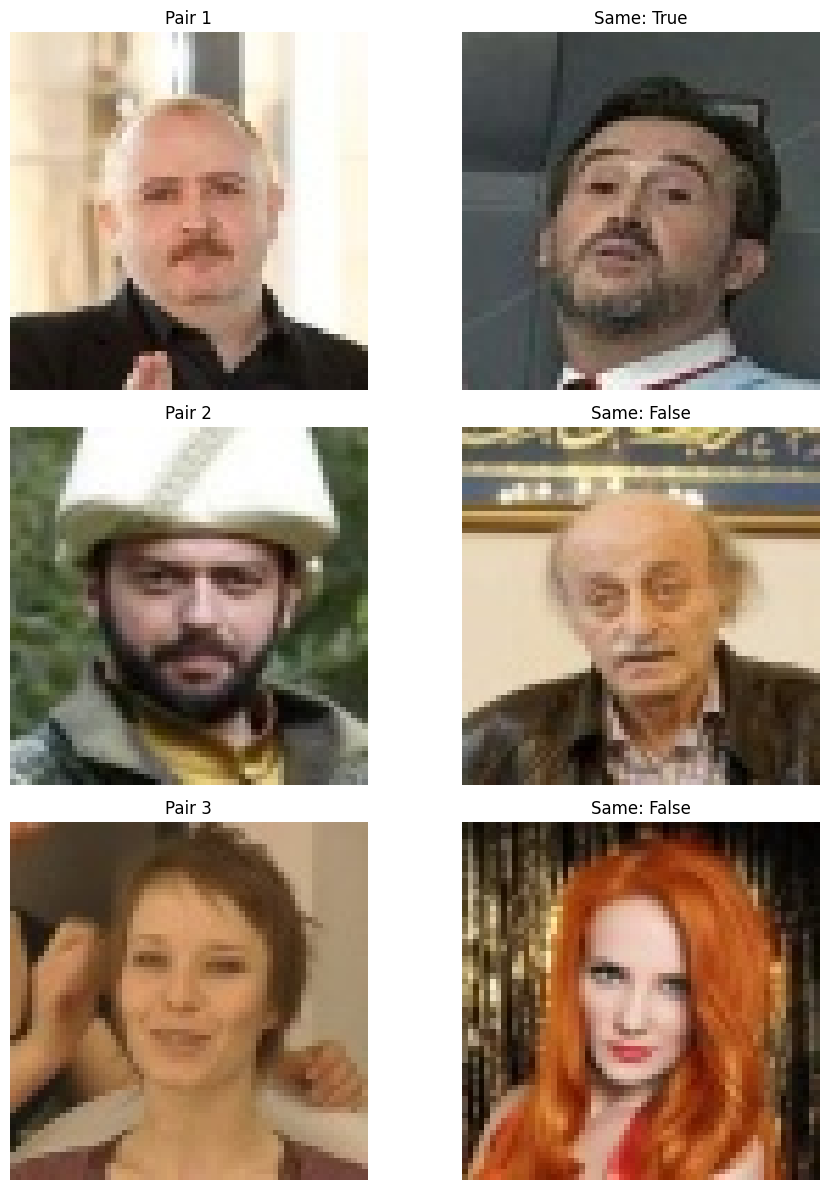

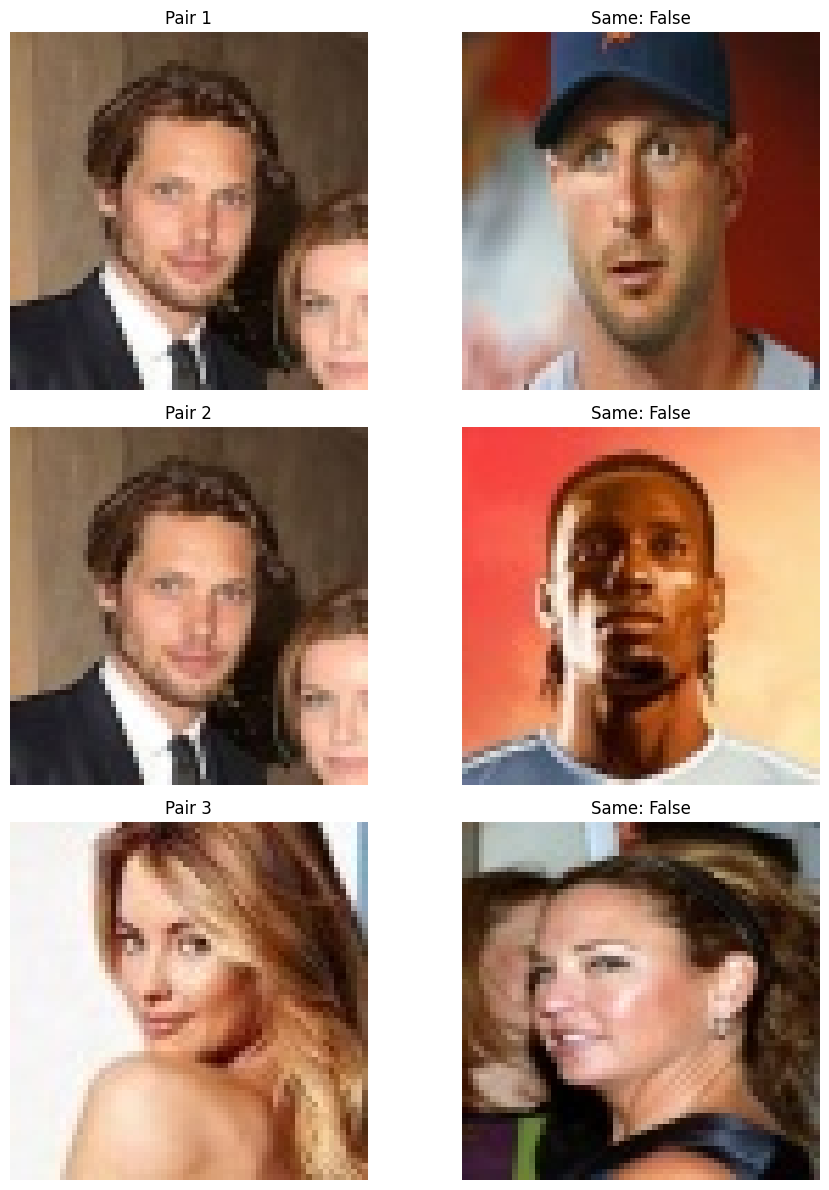

In [2]:
train_dataset = FaceDataset('dataset', split='train', return_original=True)
val_dataset = FaceDataset('dataset', split='val', return_original=True)
test_dataset = FaceDataset('dataset', split='test', return_original=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

visualize_pairs(train_dataset, num_pairs=3)
visualize_pairs(val_dataset, num_pairs=3)
visualize_pairs(test_dataset, num_pairs=3)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FaceEmbeddingCNN(nn.Module):
    def __init__(self, embedding_dim=128):
        super(FaceEmbeddingCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, embedding_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.normalize(x, p=2, dim=1)  # L2 normalization

In [6]:
def compute_similarity(embedding1, embedding2):
    return F.cosine_similarity(embedding1, embedding2)

In [7]:
import torch.optim as optim

def train_model(model, train_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.TripletMarginLoss(margin=0.2)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            optimizer.zero_grad()

            anchor_embedding = model(anchor)
            positive_embedding = model(positive)
            negative_embedding = model(negative)

            loss = criterion(anchor_embedding, positive_embedding, negative_embedding)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    return model

In [8]:
def evaluate_model(model, val_loader, threshold=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for img1, img2, labels in val_loader:
            img1, img2 = img1.to(device), img2.to(device)
            
            embedding1 = model(img1)
            embedding2 = model(img2)
            
            similarity = compute_similarity(embedding1, embedding2)
            predictions = (similarity > threshold).float()
            
            correct += (predictions == labels.to(device)).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")
    return accuracy

In [9]:
from torch.utils.data import DataLoader
# from your_dataset_file import FaceDataset  # Import your dataset class

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create datasets and dataloaders
train_dataset = FaceDataset('path/to/dataset/root', mode='train')
val_dataset = FaceDataset('path/to/dataset/root', mode='val')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Initialize the model
model = FaceEmbeddingCNN().to(device)

# Train the model
model = train_model(model, train_loader, num_epochs=10)

# Evaluate the model
evaluate_model(model, val_loader)

# Save the model
torch.save(model.state_dict(), 'face_embedding_model.pth')

TypeError: FaceDataset.__init__() got an unexpected keyword argument 'mode'